## Code visibility
Use the Show/Hide Code button on the top left to make to make the code visible or hide it. It will be hidden in the HTML files by default.

In [477]:
# RUN
import sys
sys.path.append("/opt/src")
import mip_functions as mip
import pickle
import json
import copy
import os
import numpy as np
import subprocess
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
wdir = "/opt/analysis/"
data_dir = "/opt/data/"

In [478]:
info_files = ["170828_SM_DR1_CSP_20190403.txt.gz"]
sample_sheets = ["sample_list.tsv"]
info_files = [data_dir + i for i in info_files]
sample_sheets = [data_dir + s for s in sample_sheets]
pd.concat([pd.read_table(s) for s in sample_sheets],
         ignore_index=True).groupby(["sample_set", "probe_set"]).first()

,,sample_name,replicate,fw,rev,owner,Capture Plate Name,Capture Plate Location,Library Prep,Capture Sample Set
sample_set,probe_set,,,,,,,,,
SM,"DR1,CSP",A9F6U,1,1,289,patrick,SM-Congo-Missing-01,A01,170828,SM


In [479]:
# OPTIONAL USER INPUT
sample_groups = [["SM", "DR1,CSP"]]

### Specify the species and the probe set used
These two are important parameters to determine which files will be used for analysis.  


For the species, the options are: "pf" for *Plasmodium falciparum*, "pv" for *Plasmodium vivax*, "hg19" for *Homo sapiens* genome assembly hg19/GRCh37 and "hg38" for *Homo sapiens* genome assembly hg38/GRCh38  
___
Probe sets also must be specified. Check the output of the sample sheet summary above under **probe_set** field for a reminder of what the probe set of interest is. This is usually a three letter code or codes separated by a comma. For example,  
```python
species = "pf"
probe_sets_used = "DR1,VAR4"
```

In [480]:
# USER INPUT
species =  "pf"
probe_sets_used = "DR1"

In [481]:
# OPTIONAL USER INPUT
# available cpu count
processorNumber = 20
# 
targetJoin = 1
##############      SETTINGS FOR DATA FILTERS    ##################
###################################################################
###################################################################
# Phred quality filter for individual variants. This is not used
# per variant overall, but within each sample for each variant.
minVariantQuality = 20
minVariantCoverage = 1
minVariantCount = 1
# Merge nucleotide changes happening on the same codon to convert t
# Use only for Plasmodium
mergeSNPs = 0

### Get/Set the analysis settings
Use the settings template for the species specified to get the  analysis settings and change the vaules specified in the above cell. This will create a template_settings.txt file in your analysis directory and a settings.txt file to be used for the analysis. These files also will serve as a reference of analysis settings for the sake of reproducibility.

In [482]:
# RUN

# copy the template settings file
temp_settings_file = "/opt/resources/templates/analysis_settings_templates/" + species + "_settings.txt"
subprocess.call(["scp", temp_settings_file, "/opt/analysis/template_settings.txt"])

# extract the settings template
temp_settings = mip.get_analysis_settings("/opt/analysis/template_settings.txt")

# update bwa settings with processor count
bwaOptions = temp_settings["bwaOptions"]
bwaOptions.extend(["-t", str(processorNumber)])

# Create a list from the probe_sets string
mipSetKey = probe_sets_used.split(",") + [""]

# create a dictionary for which settings should be updated
# using the user specified parameters.
update_keys = {"mipSetKey" : mipSetKey, 
               "minVariantCoverage": minVariantCoverage,
               "minVariantCount": minVariantCount,
               "minVariantQuality": minVariantQuality,
               "mergeSNPs": mergeSNPs,
               "processorNumber": processorNumber,
              "bwaOptions": bwaOptions,
              "targetJoin": targetJoin}
# update the settings
for k, v in update_keys.items():
    temp_settings[k] = v
# create a settings file in the analysis directory.
settings_file = "settings.txt"
settings_path = os.path.join(wdir, settings_file)
mip.write_analysis_settings(temp_settings, settings_path)
settings = mip.get_analysis_settings(wdir + settings_file)
# create probe sets dictionary
mip.update_probe_sets("/opt/project_resources/mip_ids/mipsets.csv",
                     "/opt/project_resources/mip_ids/probe_sets.json")

### Specify if there is a target file.
Targets file is project specific. Its default location is project_resources/ directory. For a target file project_resources/targets.tsv use:
```Python
targets_file = "/opt/project_resources/targets.tsv" 
```
If targets file is not available, **targets_file = None** should be used.  
```Python
targets_file = None
```

In [10]:
# OPTIONAL USER INPUT
targets_file = "/opt/project_resources/targets.tsv" 

### Specify how we want to add the "targeted locus" information to experiment results.
You can use:  
1. **target_join=intersection**: Filter variants so that only those in the initial targets list will remain. Annotate the variants with the information from targets file.  
2. **target_join=data**: Keep all variants in the data and annotate.  
3. **target_join=targets**: Keep only the variants in the target list (even if the variant is not observed in the data). This is useful when we're interested in knowing when a variant is not observed, such as drug resistance mutations.  
4. **target_join=union**: Keep all variants, annotate, add variants from targets file even if not observed.

In [11]:
# OPTIONAL USER INPUT
target_join = "union"

In [25]:
%%capture output
mip.combine_info_files(wdir,
                       settings_file, 
                      info_files,
                      sample_sheets,
                      settings["mipsterFile"],
                      sample_sets=sample_groups)
mip.process_haplotypes(wdir + settings_file)
mip.process_results(wdir,
                    settings_file,
                    [wdir + "samples.tsv"],
                    targets_file=targets_file,
                    target_join=target_join
                   )

In [26]:
# RUN
output.show()

5 alignments may have problems, please check alignments.tmp
102 out of 102 samples has meta information and will be used for analysis.
There are 28588 mapped and 114 unmapped (off target) haplotypes.
There are 96720 data points in raw data, 96543 are mapped to genome and their targets.
Total number of reads and barcodes were 27414531 and 7749003. On target number of reads and barcodes were 27406177 and 7746020.
There were 193096 total and 27401 unique variants, 
166243 total and 7053 unique variants remain after filtering variants for minimum total barcodes of 5, minimum observed sample number of 2, and minimum observed sample fraction of 0.0.
104755 total and 5947 unique variants remained after quality filtering for phred scores >= 20.
There are 92 samples with sequence data
There are 102 total samples.
Per sample mutation frequencies have been calculated for mutants with at least 2 supporting barcodes and loci with at least 5 coverage. Loci with less coverage will have NA frequencies

In [483]:
mip.get_vcf_haplotypes(settings)
mip.get_haplotype_counts(settings)
contig_results = mip.split_contigs(settings)
mip.merge_contigs(settings, contig_info, cpr)

2 of 4868 haplotypes were off-target, either not mapping to the reference genome, or best mapping to a region which was not targeted.


### Preview the results
Plotting the probe coverage by samples is a good  way to see overall experiment perfomance. It shows if a probe has at least 1 barcode (or however many is specified below) for a given sample.  

Dark columns point to poor performing probes whereas dark rows indicate poor samples. Note that this excludes samples with no reads at all. Use "all_barcode_counts.csv" file if those are of interest as well.

Some parameters can be supplied to the plotting function as noted in the comments.

(<Figure size 1800x1200 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcb2bdb28d0>)

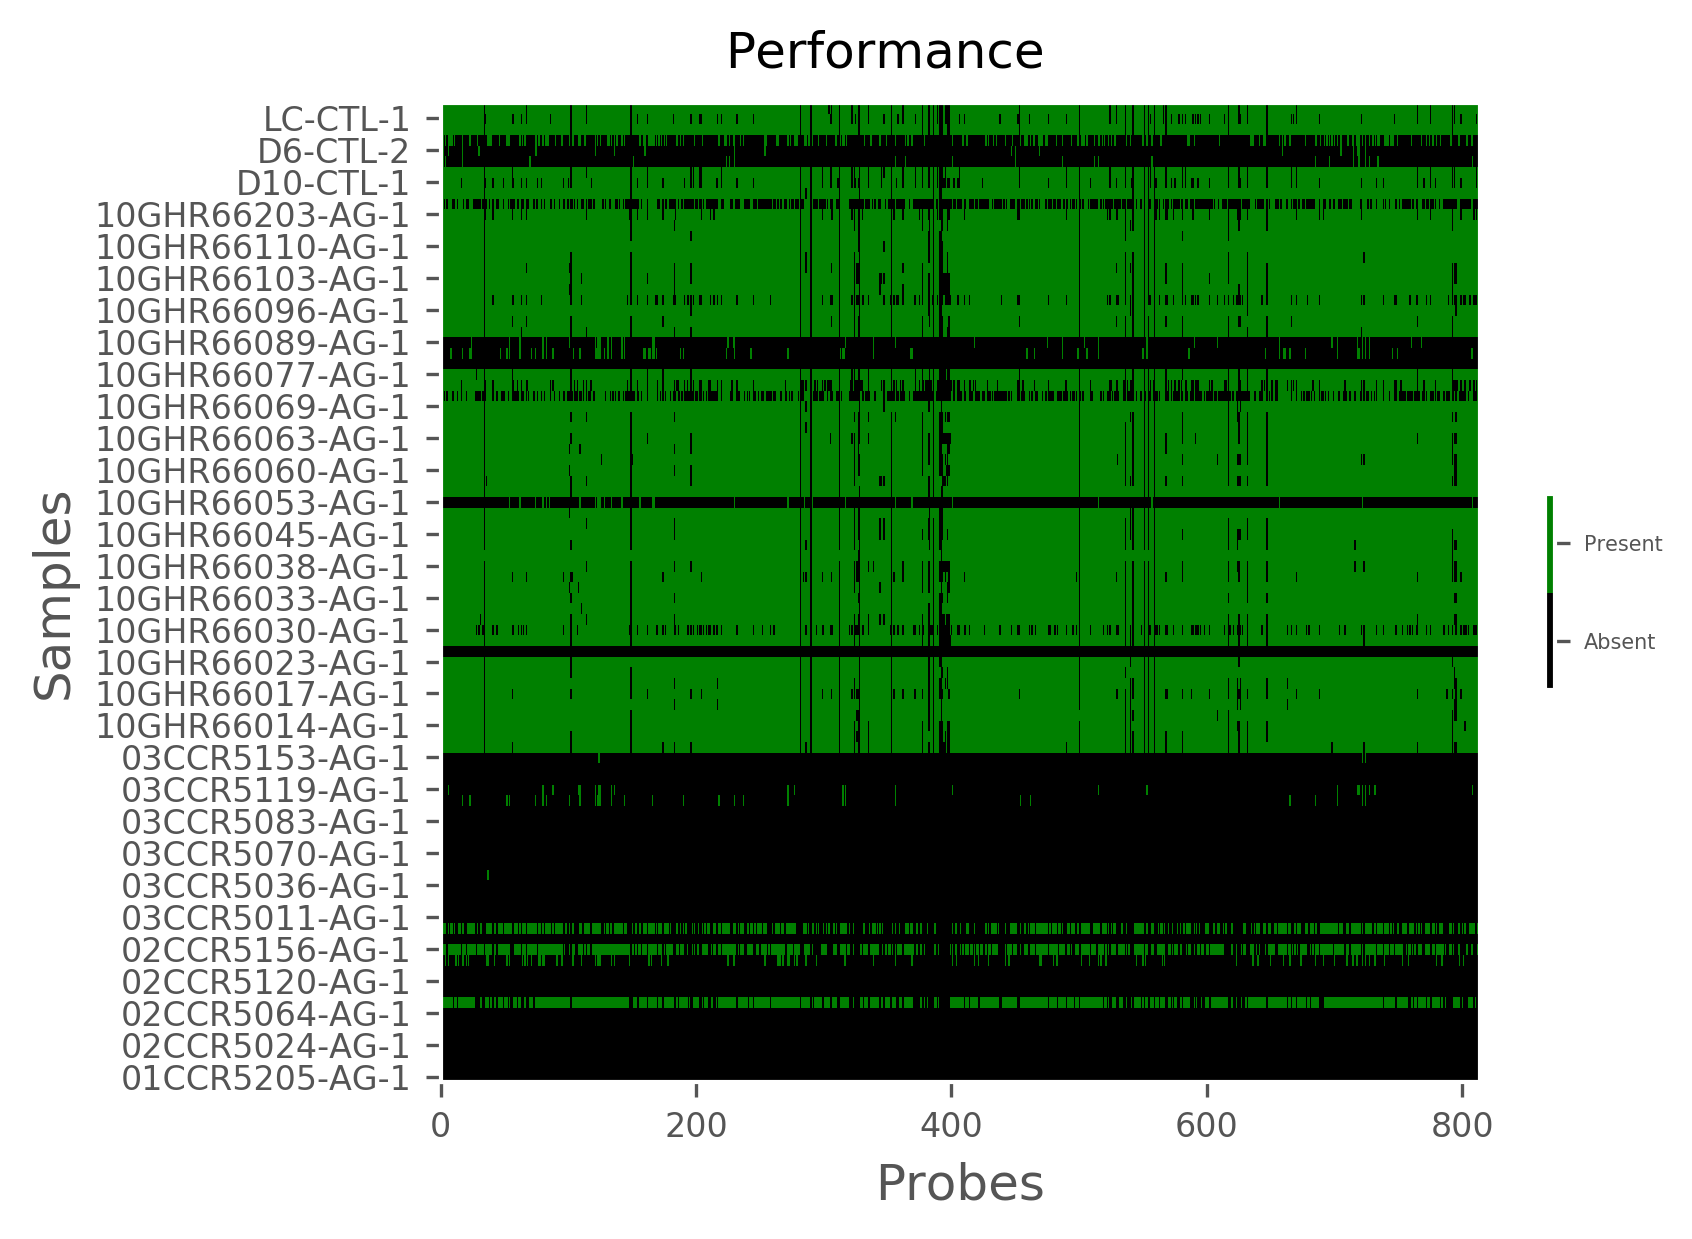

In [27]:
# OPTIONAL USER INPUT
barcode_counts = pd.read_csv(wdir + "barcode_counts.csv",
             header = [0,1], index_col = 0)
mip.plot_performance(barcode_counts,
                     barcode_threshold=10, # anything below this number will be considered absent
                     tick_label_size=8, # font size for tick labels for x and y axis
                     cbar_label_size=5, # font size for heat map color bar
                     dpi=300, # figure resolution
                     absent_color='black',
                     present_color='green',
                     save=False, # If false, plots the graph here. If true, saves a .png in the analysis dir
                    ytick_freq=None, # How frequent the y-axis ticks should be (every nth column will have  a tick)
                    xtick_freq=None,
                    xtick_rotation=90) # x-axis tick label rotation 

### Look at summary stats 
There are summary statistics and meta data (if provided) we can use to determine if coverage is enough, whether further sequencing is necessary, and how to proceed if further sequencing will be needed.

In [28]:
# RUN
sample_summary = pd.read_csv(wdir + "sample_summary.csv")
sample_summary.head()

,Sample ID,Read Count,Barcode Count,targets_with_1_barcodes,targets_with_5_barcodes,targets_with_10_barcodes
0,01CCR5205-AG-1,1076.0,78.0,65,0,0
1,01CCR5207-AG-1,353.0,27.0,26,0,0
2,02CCR5021-AG-1,202.0,11.0,10,0,0
3,02CCR5024-AG-1,374.0,30.0,27,0,0
4,02CCR5026-AG-1,103.0,11.0,11,0,0


In [29]:
# RUN
meta = pd.read_csv(wdir + "merged_meta.csv")
meta.head()

,Unnamed: 0,Sample ID,Library Prep,sample_name,probe_set,fw,rev,owner,Capture Plate Name,Capture Plate Location,sample_set,Original SID,replicate,Sample Name,Meta
0,0,01CCR5205-AG-1,180703,01CCR5205,DR2,1,265,Benedicta,K,A01,AG,01CCR5205-AG-1,1,01CCR5205,Meta
1,1,01CCR5207-AG-1,180703,01CCR5207,DR2,2,266,Benedicta,K,A02,AG,01CCR5207-AG-1,1,01CCR5207,Meta
2,2,02CCR5021-AG-1,180703,02CCR5021,DR2,3,267,Benedicta,K,A03,AG,02CCR5021-AG-1,1,02CCR5021,Meta
3,3,02CCR5024-AG-1,180703,02CCR5024,DR2,4,268,Benedicta,K,A04,AG,02CCR5024-AG-1,1,02CCR5024,Meta
4,4,02CCR5026-AG-1,180703,02CCR5026,DR2,5,269,Benedicta,K,A05,AG,02CCR5026-AG-1,1,02CCR5026,Meta


### A scatter plot of total barcode count vs number of probes covered at a certain barcode count is a good way to see how the relationship between total coverage and probe coverage, which is useful in determining how to proceed to the next experiments or analyses.

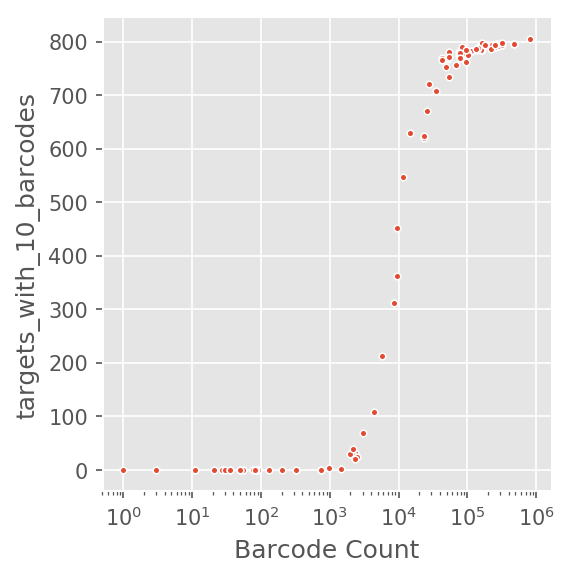

In [30]:
# RUN
f = sns.pairplot(data = sample_summary,
                x_vars = "Barcode Count",
                y_vars = "targets_with_10_barcodes",
                plot_kws={"s": 10})
f.fig.set_size_inches(5,5)
f.fig.set_dpi(150)
f.fig.axes[0].set_xscale("log")

### Plot the total read count vs the covered probe number

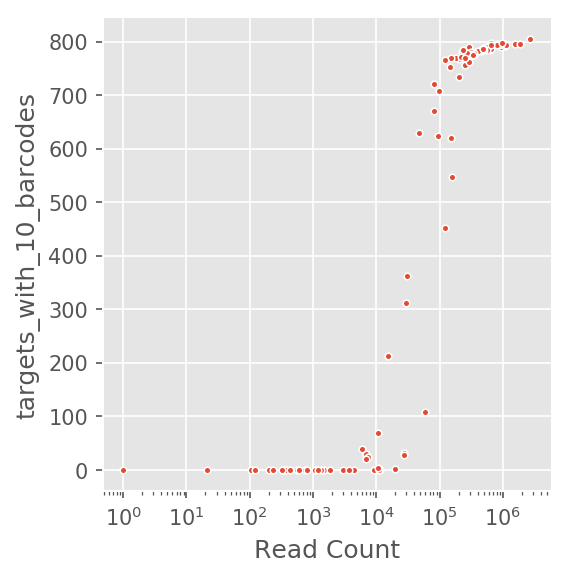

In [31]:
# RUN
f = sns.pairplot(data = sample_summary,
                x_vars = "Read Count",
                y_vars = "targets_with_10_barcodes",
                plot_kws={"s": 10})
f.fig.set_size_inches(5,5)
f.fig.set_dpi(150)
f.fig.axes[0].set_xscale("log")

### Repooling capture reactions for further sequencing. Factors to consider:
1. What do you we want to accomplish? In most cases, we would like to get enough coverage for a number of probes for each sample. For example, the test data contains **47 probes** in total. Let's say it is sufficient if we had a coverage of **10** or more for each probe for a sample. Then, we would not want to sequence any more of that sample. 
```python
target_coverage_count = 47
target_coverage_key='targets_with_10_barcodes'
```
Alternatively, we can set a goal of a fraction of total probes to reach a certain coverage rather than an absolute number of probes. For 95% of the maximum number of probes observed (47 in this case): 
```python
target_coverage_fraction = 0.95
target_coverage_key='targets_with_10_barcodes'
```
Although we set our goal to 47 probes, it is likely that some sample will never reach that number regardless of how much we sequence, if there is a deletion in the region, for example. So it makes sense to set a total coverage threshold after which we don't expect more data. Looking at the plot above, it seems like after 1000 barcode counts, we would reach our goal for most samples. 
```python
high_barcode_threshold = 10000
```
Another metric to use for determining if we want to sequence a sample more is the average read count per barcode count. This value indicates we have sequenced each unique molecular index in our sample so many times, so when the value is high, it is unlikely that we'd get more UMIs by sequencing the same library more. It makes more sense for a fresh MIP capture from these samples if more data is needed.
```python
barcode_coverage_threshold=10
```
Some samples perform very poorly for one reason or another. There are two options for these samples for repooling consideration: 1) Repool as much as we can for the next run, 2) Assuming there is a problem in the capture reaction, set up a new MIP capture reaction for these samples. It makes more sense to use option 1 if this is the first sequencing data using this library. Use option 2 if this library have been repooled at a higher volume already, but still producing poor data.
```python
barcode_count_threshold=100 # samples below total barcode count of this value is considered low coverage
low_coverage_action='Repool' # what to do for low coverage samples (Repool or Recapture)
```
Sometimes a handful of samples show uneven coverage of loci, i.e. they have very good coverage of a handful of loci but poor coverage in others, which may point to a problem with the sample or the experiment in general. These samples are determined by comparing the subset of samples that reached the goal we set (completed samples) and those that have not. We look at the number of barcodes per probe for _completed_ samples and get 25th percentile (or other percentile as set) and assume that if a sample on average has this many barcodes per target, it should have reached the set goal. For example, if on average _completed_ samples, i.e. samples that cover 47 probes at 10 barcodes or more, have 10000 total barcodes, they would have ~200 (10000/47) barcodes per target covered. And if an _incomplete_ sample has 5000 total barcodes and only 10 targets covered, this value would be 500 for that sample and it would be flagged as **uneven coverage** in repooling document.
```python
assesment_key='targets_with_1_barcodes' # coverage key to compare "complete" and "incomplete" samples
good_coverage_quantile=0.25 # percentile to set the threshold
```

In [32]:
# USER INPUT
high_barcode_threshold = 100000
target_coverage_count = None
target_coverage_fraction = 0.95
target_coverage_key='targets_with_10_barcodes'
barcode_coverage_threshold=10
barcode_count_threshold=100
low_coverage_action='Recapture'
assesment_key='targets_with_1_barcodes'
good_coverage_quantile=0.25

In [33]:
# RUN
data_summary = pd.merge(sample_summary, meta)
mip.repool(wdir, 
           data_summary, 
           high_barcode_threshold, 
           target_coverage_count=target_coverage_count, 
           target_coverage_fraction=target_coverage_fraction, 
           target_coverage_key=target_coverage_key,
           barcode_coverage_threshold=barcode_coverage_threshold,
           barcode_count_threshold=barcode_count_threshold, 
           low_coverage_action=low_coverage_action,
           assesment_key=assesment_key,
           good_coverage_quantile=good_coverage_quantile,
           output_file='repool.csv')

Out of 92 samples 42 are completed, 32 will be recaptured and 18 repooled
3 samples showed uneven coverage, 0 complete, 2 to be recaptured, 1 repooled


### Inspect the repool document
Library to completion field in the repool document has the value (volume) of how much from a sample should be pooled for re-sequencing. These values are only rough estimates and care should be taken to make sure there will be enough material to sequence.

In [34]:
pd.read_csv(wdir + "repool.csv").head()

,Sample ID,Read Count,Barcode Count,targets_with_1_barcodes,targets_with_5_barcodes,targets_with_10_barcodes,Unnamed: 0,Library Prep,sample_name,probe_set,...,replicate,Sample Name,Meta,total_barcode_count,total_read_count,Status,Barcode Coverage,Library to Completion,Barcodes Per Target Covered,Uneven Coverage
0,01CCR5205-AG-1,1076.0,78.0,65,0,0,0,180703,01CCR5205,DR2,...,1,01CCR5205,Meta,78.0,1076.0,Recapture,13.794872,1281.051282,NaN,False
1,01CCR5207-AG-1,353.0,27.0,26,0,0,1,180703,01CCR5207,DR2,...,1,01CCR5207,Meta,27.0,353.0,Recapture,13.074074,3702.703704,NaN,False
2,02CCR5021-AG-1,202.0,11.0,10,0,0,2,180703,02CCR5021,DR2,...,1,02CCR5021,Meta,11.0,202.0,Recapture,18.363636,9089.909091,NaN,False
3,02CCR5024-AG-1,374.0,30.0,27,0,0,3,180703,02CCR5024,DR2,...,1,02CCR5024,Meta,30.0,374.0,Recapture,12.466667,3332.333333,NaN,False
4,02CCR5026-AG-1,103.0,11.0,11,0,0,4,180703,02CCR5026,DR2,...,1,02CCR5026,Meta,11.0,103.0,Recapture,9.363636,9089.909091,NaN,False


### Lets look at some files generated from the data
**variant_table.csv** file in your analysis directory contains all the variants passing filters specified in the settings file. The values in the table are each variant's ALT allele barcode depth in a given sample. Note that the value in paranthesis **range(12)** must match the number of header lines in the file. This depends on how many information fields from targets file are retained for final analysis. Experiment with values (9-12) to get the correct value that leaves only the numbers/values in the table and all other information on the column headers.

In [35]:
variant_counts = pd.read_csv(
    wdir + "variant_table.csv", 
    header = list(range(12)), index_col = 0
)
variant_counts.head()

CHROM                                   chr1                          \
POS                                 190260.0                190271.0   
ID                                         .                       .   
REF                                        G                       G   
ALT                                        A                    GTCT   
Gene                                  Pfubp1                  Pfubp1   
Mutation Name       Pfubp1-chr1:190260:.:G:A       Pfubp1-M1delinsMS   
AA Change Position                         .               M1delinsM   
ExonicFunc                                 . nonframeshift insertion   
Reference Resistant                       No                      No   
Targeted                                  No                      No   
Multi Mapping                             No                      No   
Sample ID                                                              
01CCR5205-AG-1                           0.0                     0.0   
01CCR5207-AG-1                           0.0                     0.0   
02CCR5021-AG-1                           0.0                     0.0   
02CCR5024-AG-1                           0.0                     0.0   
02CCR5026-AG-1                           0.0                     0.0   

CHROM                                                          \
POS                          190317.0                           
ID                                  .                           
REF                                 C                           
ALT                                 A                    CATA   
Gene                           Pfubp1                  Pfubp1   
Mutation Name             Pfubp1-H17N      Pfubp1-H17delinsHN   
AA Change Position                H17              H17delinsH   
ExonicFunc          nonsynonymous SNV nonframeshift insertion   
Reference Resistant                No                      No   
Targeted                           No                      No   
Multi Mapping                      No                      No   
Sample ID                                                       
01CCR5205-AG-1                    0.0                     0.0   
01CCR5207-AG-1                    0.0                     0.0   
02CCR5021-AG-1                    0.0                     0.0   
02CCR5024-AG-1                    0.0                     0.0   
02CCR5026-AG-1                    0.0                     0.0   

CHROM                                                                \
POS                                                                   
ID                                                                    
REF                                                                   
ALT                                 CATAATA              CATAATAATA   
Gene                                 Pfubp1                  Pfubp1   
Mutation Name           Pfubp1-H17delinsHNN    Pfubp1-H17delinsHNNN   
AA Change Position              H17delinsHN            H17delinsHNN   
ExonicFunc          nonframeshift insertion nonframeshift insertion   
Reference Resistant                      No                      No   
Targeted                                 No                      No   
Multi Mapping                            No                      No   
Sample ID                                                             
01CCR5205-AG-1                          0.0                     0.0   
01CCR5207-AG-1                          0.0                     0.0   
02CCR5021-AG-1                          0.0                     0.0   
02CCR5024-AG-1                          0.0                     0.0   
02CCR5026-AG-1                          0.0                     0.0   

CHROM                                                               \
POS                                                                  
ID                                                                   
REF                                        

**variant_coverage_table.csv** file has the same structure as the variant_table file. The values in this table has the _total coverage_ for the locus of each variant in each sample.

In [36]:
variant_coverage = pd.read_csv(
    wdir + "variant_coverage_table.csv", 
    header = list(range(12)), index_col = 0
)
variant_coverage.head()

CHROM                                   chr1                          \
POS                                 190260.0                190271.0   
ID                                         .                       .   
REF                                        G                       G   
ALT                                        A                    GTCT   
Gene                                  Pfubp1                  Pfubp1   
Mutation Name       Pfubp1-chr1:190260:.:G:A       Pfubp1-M1delinsMS   
AA Change Position                         .               M1delinsM   
ExonicFunc                                 . nonframeshift insertion   
Reference Resistant                       No                      No   
Targeted                                  No                      No   
Multi Mapping                             No                      No   
Sample ID                                                              
01CCR5205-AG-1                           0.0                     0.0   
01CCR5207-AG-1                           0.0                     0.0   
02CCR5021-AG-1                           0.0                     0.0   
02CCR5024-AG-1                           0.0                     0.0   
02CCR5026-AG-1                           0.0                     0.0   

CHROM                                                          \
POS                          190317.0                           
ID                                  .                           
REF                                 C                           
ALT                                 A                    CATA   
Gene                           Pfubp1                  Pfubp1   
Mutation Name             Pfubp1-H17N      Pfubp1-H17delinsHN   
AA Change Position                H17              H17delinsH   
ExonicFunc          nonsynonymous SNV nonframeshift insertion   
Reference Resistant                No                      No   
Targeted                           No                      No   
Multi Mapping                      No                      No   
Sample ID                                                       
01CCR5205-AG-1                    0.0                     0.0   
01CCR5207-AG-1                    0.0                     0.0   
02CCR5021-AG-1                    0.0                     0.0   
02CCR5024-AG-1                    0.0                     0.0   
02CCR5026-AG-1                    0.0                     0.0   

CHROM                                                                \
POS                                                                   
ID                                                                    
REF                                                                   
ALT                                 CATAATA              CATAATAATA   
Gene                                 Pfubp1                  Pfubp1   
Mutation Name           Pfubp1-H17delinsHNN    Pfubp1-H17delinsHNNN   
AA Change Position              H17delinsHN            H17delinsHNN   
ExonicFunc          nonframeshift insertion nonframeshift insertion   
Reference Resistant                      No                      No   
Targeted                                 No                      No   
Multi Mapping                            No                      No   
Sample ID                                                             
01CCR5205-AG-1                          0.0                     0.0   
01CCR5207-AG-1                          0.0                     0.0   
02CCR5021-AG-1                          0.0                     0.0   
02CCR5024-AG-1                          0.0                     0.0   
02CCR5026-AG-1                          0.0                     0.0   

CHROM                                                               \
POS                                                                  
ID                                                                   
REF                                        

#### We can easily get within sample allele frequency of each variant by dividing variant table by coverage table.  

In [37]:
freq_table = variant_counts/variant_coverage
freq_table.head()

CHROM                                   chr1                          \
POS                                 190260.0                190271.0   
ID                                         .                       .   
REF                                        G                       G   
ALT                                        A                    GTCT   
Gene                                  Pfubp1                  Pfubp1   
Mutation Name       Pfubp1-chr1:190260:.:G:A       Pfubp1-M1delinsMS   
AA Change Position                         .               M1delinsM   
ExonicFunc                                 . nonframeshift insertion   
Reference Resistant                       No                      No   
Targeted                                  No                      No   
Multi Mapping                             No                      No   
Sample ID                                                              
01CCR5205-AG-1                           NaN                     NaN   
01CCR5207-AG-1                           NaN                     NaN   
02CCR5021-AG-1                           NaN                     NaN   
02CCR5024-AG-1                           NaN                     NaN   
02CCR5026-AG-1                           NaN                     NaN   

CHROM                                                          \
POS                          190317.0                           
ID                                  .                           
REF                                 C                           
ALT                                 A                    CATA   
Gene                           Pfubp1                  Pfubp1   
Mutation Name             Pfubp1-H17N      Pfubp1-H17delinsHN   
AA Change Position                H17              H17delinsH   
ExonicFunc          nonsynonymous SNV nonframeshift insertion   
Reference Resistant                No                      No   
Targeted                           No                      No   
Multi Mapping                      No                      No   
Sample ID                                                       
01CCR5205-AG-1                    NaN                     NaN   
01CCR5207-AG-1                    NaN                     NaN   
02CCR5021-AG-1                    NaN                     NaN   
02CCR5024-AG-1                    NaN                     NaN   
02CCR5026-AG-1                    NaN                     NaN   

CHROM                                                                \
POS                                                                   
ID                                                                    
REF                                                                   
ALT                                 CATAATA              CATAATAATA   
Gene                                 Pfubp1                  Pfubp1   
Mutation Name           Pfubp1-H17delinsHNN    Pfubp1-H17delinsHNNN   
AA Change Position              H17delinsHN            H17delinsHNN   
ExonicFunc          nonframeshift insertion nonframeshift insertion   
Reference Resistant                      No                      No   
Targeted                                 No                      No   
Multi Mapping                            No                      No   
Sample ID                                                             
01CCR5205-AG-1                          NaN                     NaN   
01CCR5207-AG-1                          NaN                     NaN   
02CCR5021-AG-1                          NaN                     NaN   
02CCR5024-AG-1                          NaN                     NaN   
02CCR5026-AG-1                          NaN                     NaN   

CHROM                                                               \
POS                                                                  
ID                                                                   
REF                                        

Genotypes can also be generated using these frequencies and some count filters.  
Possible filters:    
1.  **min_coverage**: how many barcodes are needed to for a genomic position for a sample to reliable call (possible mixed or heterozygous) genotypes. If we set min_coverage = 10, any locus within a sample that is covered below this threshold will have an NA genotype.
2.  **min_count**: if a genomic position have enough coverage, how many barcodes supporting an ALT (non-REF) base call is needed for a reliable call. If we set min_count = 2, any variant with an ALT call that has less than 2 barcodes supporting the ALT call will revert to REF.
3.  **min_freq**: a minimum within sample allele frequency threshold to consider a variant valid. If set to 0.01, for example, a variant locus in a sample that is at 0.005 frequency for the ALT allele within the sample, the locus would be called REF, if the within sample AF is between 0.01 and 0.99, it would be considered HET, and if > 0.99, it would be homozygous ALT.
```Python
# filter mutation counts for minimum count parameter by setting counts to zero if it is below threshold
variant_counts = variant_counts.applymap(lambda x: 0 if x < min_count else x)
# filter loci without enough coverage by setting coverage to zero if it is below threshold
variant_coverage = variant_coverage.applymap(lambda x: 0 if x < min_coverage else x)
# calculate within sample frequency
freq = variant_counts / variant_coverage
# call genotypes using the minimum within sample allele frequency parameter from the settings file
geno = freq.applymap(lambda x: np.nan if (np.isnan(x) or np.isinf(x))
                     else 0 if x < min_freq
                     else 1 if x < (1 - min_freq)
                     else 2)
```

### Amino acid changes
While variant specific files have information on base changes, there are also files that deal with amino acid changes only, referred to as mutations here as opposed to variants.  

The main difference between two types of data is that while two variants that are leading to the same amino acid change are considered separate variants, they would constitute the **same** mutation. A sample may have, for example, multiple distinct variants that correspond to the same *mutation* and all counts for those variants would be counted cumulatively for the single mutation call.  

Another important distinction between the variants and mutations is that the variants only deal with REF and ALT alleles. While mutations are classified as MUT or WT. While most of the time the ALT allele corresponds to the MUT call, it is sometimes possible that the REF allele encodes a mutation. The only example we have for this so far is the dhps-A437G allele which encodes a drug resistance mutation, Alanine being the WT allele and Glycine the drug resistant mutant. The 3d7 reference strain has the G allele. So when dealing with *variants* the A allele would be the ALT and G the REF, but they would be reversed to A:WT and G:MUT for mutation calls. This must be specified in the targets file by setting the "Reference Resistant" column value to "Yes".

### Below we'll preview the count, coverage and genotype files for the *mutations*
First, alternate allele counts.

In [38]:
mutation_counts = pd.read_csv(wdir + "mutant_table.csv",
                           index_col=0, header=list(range(4)))
mutation_counts.head()

Gene                       DHODH                              \
Mutation Name        DHODH-L351V DHODH-M1X       DHODH-N110Y   
Targeted                      No        No                No   
ExonicFunc     nonsynonymous SNV  stopgain nonsynonymous SNV   
Sample ID                                                      
01CCR5205-AG-1               0.0       0.0               0.0   
01CCR5207-AG-1               0.0       0.0               0.0   
02CCR5021-AG-1               0.0       0.0               0.0   
02CCR5024-AG-1               0.0       0.0               0.0   
02CCR5026-AG-1               0.0       0.0               0.0   

Gene                                                         PF3D7-0218600  \
Mutation Name         DHODH-S477fs       DHODH-V232I PF3D7-0218600-*2381fs   
Targeted                        No                No                    No   
ExonicFunc     frameshift deletion nonsynonymous SNV   frameshift deletion   
Sample ID                                                                    
01CCR5205-AG-1                 0.0               0.0                   0.0   
01CCR5207-AG-1                 0.0               0.0                   0.0   
02CCR5021-AG-1                 0.0               0.0                   0.0   
02CCR5024-AG-1                 0.0               0.0                   0.0   
02CCR5026-AG-1                 0.0               0.0                   0.0   

Gene                                                                  \
Mutation Name  PF3D7-0218600-1215_1216del PF3D7-0218600-1318_1319del   
Targeted                               No                         No   
ExonicFunc         nonframeshift deletion     nonframeshift deletion   
Sample ID                                                              
01CCR5205-AG-1                        0.0                        0.0   
01CCR5207-AG-1                        0.0                        0.0   
02CCR5021-AG-1                        0.0                        0.0   
02CCR5024-AG-1                        0.0                        0.0   
02CCR5026-AG-1                        0.0                        0.0   

Gene                                                                  \
Mutation Name  PF3D7-0218600-1464_1469del PF3D7-0218600-1464_1470del   
Targeted                               No                         No   
ExonicFunc         nonframeshift deletion     nonframeshift deletion   
Sample ID                                                              
01CCR5205-AG-1                        0.0                        0.0   
01CCR5207-AG-1                        0.0                        0.0   
02CCR5021-AG-1                        0.0                        0.0   
02CCR5024-AG-1                        0.0                        0.0   
02CCR5026-AG-1                        0.0                        0.0   

Gene                  ...                            pfv-atpase  \
Mutation Name         ...        pfv-atpase-chr13:1650786:.:G:T   
Targeted              ...                                    No   
ExonicFunc            ...                                     .   
Sample ID             ...                                         
01CCR5205-AG-1        ...                                   0.0   
01CCR5207-AG-1        ...                                   0.0   
02CCR5021-AG-1        ...                                   0.0   
02CCR5024-AG-1        ...                                   0.0   
02CCR5026-AG-1        ...                                   0.0   

Gene                                           \
Mutation Name  pfv-atpase-chr13:1650789:.:A:T   
Targeted                                   No   
ExonicFunc                                  .   
Sample ID                                       
01CCR5205-AG-1                            0.0   
01CCR5207-AG-1                            0.0   
02CCR5021-AG-1                            0.0   
02CCR5024-AG-1                            0.0   
02CCR5026-AG-1          

### Coverage

In [39]:
mutation_coverage = pd.read_csv(wdir + "mutant_coverage.csv",
                           index_col=0, header=list(range(4)))
mutation_coverage.head()

Gene                       DHODH                              \
Mutation Name        DHODH-L351V DHODH-M1X       DHODH-N110Y   
Targeted                      No        No                No   
ExonicFunc     nonsynonymous SNV  stopgain nonsynonymous SNV   
Sample ID                                                      
01CCR5205-AG-1               0.0       0.0               0.0   
01CCR5207-AG-1               0.0       0.0               0.0   
02CCR5021-AG-1               0.0       1.0               0.0   
02CCR5024-AG-1               0.0       0.0               1.0   
02CCR5026-AG-1               0.0       0.0               0.0   

Gene                                                         PF3D7-0218600  \
Mutation Name         DHODH-S477fs       DHODH-V232I PF3D7-0218600-*2381fs   
Targeted                        No                No                    No   
ExonicFunc     frameshift deletion nonsynonymous SNV   frameshift deletion   
Sample ID                                                                    
01CCR5205-AG-1                 0.0               1.0                   0.0   
01CCR5207-AG-1                 0.0               0.0                   0.0   
02CCR5021-AG-1                 1.0               0.0                   0.0   
02CCR5024-AG-1                 0.0               0.0                   0.0   
02CCR5026-AG-1                 0.0               0.0                   0.0   

Gene                                                                  \
Mutation Name  PF3D7-0218600-1215_1216del PF3D7-0218600-1318_1319del   
Targeted                               No                         No   
ExonicFunc         nonframeshift deletion     nonframeshift deletion   
Sample ID                                                              
01CCR5205-AG-1                        0.0                        0.0   
01CCR5207-AG-1                        0.0                        0.0   
02CCR5021-AG-1                        0.0                        0.0   
02CCR5024-AG-1                        0.0                        0.0   
02CCR5026-AG-1                        0.0                        0.0   

Gene                                                                  \
Mutation Name  PF3D7-0218600-1464_1469del PF3D7-0218600-1464_1470del   
Targeted                               No                         No   
ExonicFunc         nonframeshift deletion     nonframeshift deletion   
Sample ID                                                              
01CCR5205-AG-1                        0.0                        0.0   
01CCR5207-AG-1                        0.0                        0.0   
02CCR5021-AG-1                        0.0                        0.0   
02CCR5024-AG-1                        0.0                        0.0   
02CCR5026-AG-1                        0.0                        0.0   

Gene                  ...                            pfv-atpase  \
Mutation Name         ...        pfv-atpase-chr13:1650786:.:G:T   
Targeted              ...                                    No   
ExonicFunc            ...                                     .   
Sample ID             ...                                         
01CCR5205-AG-1        ...                                   0.0   
01CCR5207-AG-1        ...                                   0.0   
02CCR5021-AG-1        ...                                   0.0   
02CCR5024-AG-1        ...                                   0.0   
02CCR5026-AG-1        ...                                   0.0   

Gene                                           \
Mutation Name  pfv-atpase-chr13:1650789:.:A:T   
Targeted                                   No   
ExonicFunc                                  .   
Sample ID                                       
01CCR5205-AG-1                            0.0   
01CCR5207-AG-1                            0.0   
02CCR5021-AG-1                            0.0   
02CCR5024-AG-1                            0.0   
02CCR5026-AG-1          

**Genotypes** for mutations can also be generated in a similar way to the genotypes for variants.  
Possible filters:    
1.  **min_coverage**: how many barcodes are needed to for a genomic position for a sample to reliable call (possible mixed or heterozygous) genotypes. If we set min_coverage = 10, any locus within a sample that is covered below this threshold will have an NA genotype.
2.  **min_count**: if a genomic position have enough coverage, how many barcodes supporting an MUT (non-WT) aminoacid call is needed for a reliable call. If we set min_count = 2, any mutation with an MUT call that has less than 2 barcodes supporting the MUT call will revert to WT.
3.  **min_freq**: a minimum within sample allele frequency threshold to consider a variant valid. If set to 0.01, for example, a variant locus in a sample that is at 0.005 frequency for the MUT allele within the sample, the locus would be called WT, if the within sample AF is between 0.01 and 0.99, it would be considered HET, and if > 0.99, it would be homozygous MUT.
```Python
# filter mutation counts for minimum count parameter by setting counts to zero if it is below threshold
mutation_counts = mutation_counts.applymap(lambda x: 0 if x < min_count else x)
# filter loci without enough coverage by setting coverage to zero if it is below threshold
mutation_coverage = mutation_coverage.applymap(lambda x: 0 if x < min_coverage else x)
# calculate within sample frequency
freq = mutation_counts / mutation_coverage
# call genotypes using the minimum within sample allele frequency parameter from the settings file
geno = freq.applymap(lambda x: np.nan if (np.isnan(x) or np.isinf(x))
                     else 0 if x < min_freq
                     else 1 if x < (1 - min_freq)
                     else 2)
```

A genotypes.csv file is already generated using the cut off values provided in the settings file.

In [40]:
min_count = 2
min_coverage = 10
min_freq = 0.01
# filter mutation counts for minimum count parameter by setting counts to zero if it is below threshold
mutation_counts = mutation_counts.applymap(lambda x: 0 if x < min_count else x)
# filter loci without enough coverage by setting coverage to zero if it is below threshold
mutation_coverage = mutation_coverage.applymap(lambda x: 0 if x < min_coverage else x)
# calculate within sample frequency
freq = mutation_counts / mutation_coverage
# call genotypes using the minimum within sample allele frequency parameter from the settings file
genotypes = freq.applymap(lambda x: np.nan if (np.isnan(x) or np.isinf(x))
                 else 0 if x < min_freq
                 else 1 if x < (1 - min_freq)
                 else 2)

### How well have we been able to genotype the targeted mutation loci?
Limiting the genotypes to the targeted loci.

In [41]:
targeted_mutations = genotypes.xs("Yes", level="Targeted", axis=1)
targeted_mutations.head()

Gene                 PF3D7-1322700      PF3D7-1451200       Sec14  \
Mutation Name  PF3D7-1322700-T236I PF3D7-1451200-N71N Sec14-L498F   
ExonicFunc       nonsynonymous SNV     synonymous SNV          NA   
Sample ID                                                           
01CCR5205-AG-1                 NaN                NaN         NaN   
01CCR5207-AG-1                 NaN                NaN         NaN   
02CCR5021-AG-1                 NaN                NaN         NaN   
02CCR5024-AG-1                 NaN                NaN         NaN   
02CCR5026-AG-1                 NaN                NaN         NaN   

Gene                                   arps10              atp6  \
Mutation Name        Sec14-N615D arps10-V127M        atp6-A623E   
ExonicFunc     nonsynonymous SNV           NA nonsynonymous SNV   
Sample ID                                                         
01CCR5205-AG-1               NaN          NaN               NaN   
01CCR5207-AG-1               NaN          NaN               NaN   
02CCR5021-AG-1               NaN          NaN               NaN   
02CCR5024-AG-1               NaN          NaN               NaN   
02CCR5026-AG-1               NaN          NaN               NaN   

Gene                                                                 crt  \
Mutation Name         atp6-E431K atp6-L263E atp6-S769N         crt-A220S   
ExonicFunc     nonsynonymous SNV         NA         NA nonsynonymous SNV   
Sample ID                                                                  
01CCR5205-AG-1               NaN        NaN        NaN               NaN   
01CCR5207-AG-1               NaN        NaN        NaN               NaN   
02CCR5021-AG-1               NaN        NaN        NaN               NaN   
02CCR5024-AG-1               NaN        NaN        NaN               NaN   
02CCR5026-AG-1               NaN        NaN        NaN               NaN   

Gene                  ...                  kelch10       mcp  \
Mutation Name         ...            kelch10-P623T mcp-N252D   
ExonicFunc            ...        nonsynonymous SNV        NA   
Sample ID             ...                                      
01CCR5205-AG-1        ...                      NaN       NaN   
01CCR5207-AG-1        ...                      NaN       NaN   
02CCR5021-AG-1        ...                      NaN       NaN   
02CCR5024-AG-1        ...                      NaN       NaN   
02CCR5026-AG-1        ...                      NaN       NaN   

Gene                        mdr1                                      \
Mutation Name        mdr1-D1246Y       mdr1-N1042D         mdr1-N86Y   
ExonicFunc     nonsynonymous SNV nonsynonymous SNV nonsynonymous SNV   
Sample ID                                                              
01CCR5205-AG-1               NaN               NaN               NaN   
01CCR5207-AG-1               NaN               NaN               NaN   
02CCR5021-AG-1               NaN               NaN               NaN   
02CCR5024-AG-1               NaN               NaN               NaN   
02CCR5026-AG-1               NaN               NaN               NaN   

Gene                                                            mdr2  \
Mutation Name        mdr1-S1034C        mdr1-Y184F        mdr2-T484I   
ExonicFunc     nonsynonymous SNV nonsynonymous SNV nonsynonymous SNV   
Sample ID                                                              
01CCR5205-AG-1               NaN               NaN               NaN   
01CCR5207-AG-1               NaN               NaN               NaN   
02CCR5021-AG-1               NaN               NaN               NaN   
02CCR5024-AG-1               NaN               NaN               NaN   
02CCR5026-AG-1               NaN               NaN               NaN   

Gene                  pib7               pph  
Mutation Name  pib7-C1484F        pph-V1157L  
ExonicFunc              NA nonsynonymous SNV  
Sample ID                                     
01CCR5205-AG-1         NaN

### Get the percentage of samples successfully genotyped at target loci for each mutation

In [42]:
targeted_mutations.count()*100/targeted_mutations.shape[0]

Gene           Mutation Name        ExonicFunc       
PF3D7-1322700  PF3D7-1322700-T236I  nonsynonymous SNV    72.826087
PF3D7-1451200  PF3D7-1451200-N71N   synonymous SNV       60.869565
Sec14          Sec14-L498F          NA                    0.000000
               Sec14-N615D          nonsynonymous SNV    63.043478
arps10         arps10-V127M         NA                   61.956522
atp6           atp6-A623E           nonsynonymous SNV    65.217391
               atp6-E431K           nonsynonymous SNV    61.956522
               atp6-L263E           NA                   66.304348
               atp6-S769N           NA                   57.608696
crt            crt-A220S            nonsynonymous SNV    54.347826
               crt-C101F            NA                   61.956522
               crt-C72S             nonsynonymous SNV    61.956522
               crt-F145I            NA                   57.608696
               crt-H97L             NA                   61.956522
        

### Limit the analysis to the control samples to see the affect of parasite density and DNA quality
What controls samples have been used.

In [44]:
control_samples = [s for s in targeted_mutations.index if "CTL" in s]
control_samples

['D10-CTL-1',
 'D10-CTL-2',
 'D6-CTL-1',
 'D6-CTL-2',
 'HC-CTL-1',
 'HC-CTL-2',
 'LC-CTL-1',
 'LC-CTL-2']

### Genotyping rate for controls

In [45]:
controls = targeted_mutations.loc[control_samples]
controls.count()*100/controls.shape[0]

Gene           Mutation Name        ExonicFunc       
PF3D7-1322700  PF3D7-1322700-T236I  nonsynonymous SNV    100.0
PF3D7-1451200  PF3D7-1451200-N71N   synonymous SNV        75.0
Sec14          Sec14-L498F          NA                     0.0
               Sec14-N615D          nonsynonymous SNV     87.5
arps10         arps10-V127M         NA                    75.0
atp6           atp6-A623E           nonsynonymous SNV    100.0
               atp6-E431K           nonsynonymous SNV     75.0
               atp6-L263E           NA                    75.0
               atp6-S769N           NA                    62.5
crt            crt-A220S            nonsynonymous SNV     62.5
               crt-C101F            NA                    75.0
               crt-C72S             nonsynonymous SNV     75.0
               crt-F145I            NA                    62.5
               crt-H97L             NA                    75.0
               crt-H97Y             NA                    75.0
 

### Compare high density vs low density controls (>500 parasites / µ (DNA) are high density)

In [46]:
hc = ['D10-CTL-1',
 'D10-CTL-2',
 'HC-CTL-1',
 'HC-CTL-2']
lc = [
 'D6-CTL-1',
 'D6-CTL-2',
 'LC-CTL-1',
 'LC-CTL-2']

lc = targeted_mutations.loc[lc]
hc = targeted_mutations.loc[hc]


### Low density controls genotyping rate

In [47]:
lc.count()*100/lc.shape[0]

Gene           Mutation Name        ExonicFunc       
PF3D7-1322700  PF3D7-1322700-T236I  nonsynonymous SNV    100.0
PF3D7-1451200  PF3D7-1451200-N71N   synonymous SNV        50.0
Sec14          Sec14-L498F          NA                     0.0
               Sec14-N615D          nonsynonymous SNV     75.0
arps10         arps10-V127M         NA                    50.0
atp6           atp6-A623E           nonsynonymous SNV    100.0
               atp6-E431K           nonsynonymous SNV     50.0
               atp6-L263E           NA                    50.0
               atp6-S769N           NA                    50.0
crt            crt-A220S            nonsynonymous SNV     50.0
               crt-C101F            NA                    50.0
               crt-C72S             nonsynonymous SNV     50.0
               crt-F145I            NA                    50.0
               crt-H97L             NA                    50.0
               crt-H97Y             NA                    50.0
 

### High density samples genotyping rates

In [48]:
hc.count()*100/hc.shape[0]

Gene           Mutation Name        ExonicFunc       
PF3D7-1322700  PF3D7-1322700-T236I  nonsynonymous SNV    100.0
PF3D7-1451200  PF3D7-1451200-N71N   synonymous SNV       100.0
Sec14          Sec14-L498F          NA                     0.0
               Sec14-N615D          nonsynonymous SNV    100.0
arps10         arps10-V127M         NA                   100.0
atp6           atp6-A623E           nonsynonymous SNV    100.0
               atp6-E431K           nonsynonymous SNV    100.0
               atp6-L263E           NA                   100.0
               atp6-S769N           NA                    75.0
crt            crt-A220S            nonsynonymous SNV     75.0
               crt-C101F            NA                   100.0
               crt-C72S             nonsynonymous SNV    100.0
               crt-F145I            NA                    75.0
               crt-H97L             NA                   100.0
               crt-H97Y             NA                   100.0
 

Cytb probes were added at a much lower concentration compared to the other probes due to multiple copies of mitochondrial DNA being present in each cell. The low rate of these calls should be easy to fix by adding more cytb probes.  

Sec14-L498F probe designed had failed, so it is normal to have 0 calls for this mutation.

### Get the metadata for the samples used

In [49]:
meta = pd.read_table("/tmp/AG_surveys_meta.tsv")
meta.head()

,Sample Name,Age,Sex,Weight,Height,HB,Parasitaemia,Species,Year,Survey,Study Site,Pool
0,01BGR1007,6.0,F,16.0,112.2,10.6,16.0,Pf,2013,School,Begoro,No
1,01BGR1008,8.0,F,25.0,127.0,14.6,256.0,Pf,2013,School,Begoro,No
2,01BGR1009,7.0,F,19.0,114.8,11.2,2320.0,Pf,2013,School,Begoro,No
3,01BGR1010,9.0,F,23.0,126.6,13.0,32.0,Pf,2013,School,Begoro,No
4,01BGR1011,6.0,F,19.0,114.0,12.8,1200.0,Pf,2013,School,Begoro,No


In [56]:
run_meta = pd.read_csv(wdir + "run_meta.csv")
run_meta.drop(["Unnamed: 0", "Library Prep", "probe_set", "sample_set", "replicate"],
             axis=1, inplace=True)
merged_meta = run_meta.merge(meta, how="left")
summary = sample_summary.merge(merged_meta, how="outer")
summary.rename(columns={"targets_with_1_barcodes": 1,
                       "targets_with_5_barcodes": 5,
                       "targets_with_10_barcodes": 10},
              inplace=True)
summary["Barcode Coverage"] = summary["Read Count"] / summary["Barcode Count"]
summary.columns

Index([             'Sample ID',             'Read Count',
                'Barcode Count',                        1,
                              5,                       10,
                  'sample_name',                     'fw',
                          'rev',                  'owner',
           'Capture Plate Name', 'Capture Plate Location',
                 'Original SID',            'Sample Name',
                          'Age',                    'Sex',
                       'Weight',                 'Height',
                           'HB',           'Parasitaemia',
                      'Species',                   'Year',
                       'Survey',             'Study Site',
                         'Pool',       'Barcode Coverage'],
      dtype='object')

### Generate plots of relevant count data to explore data a little more

Read count vs barcode count: we should see a proportional increase. Also, we don't want the read count / barcode count ratio to be too high (ideally lower than 10). 

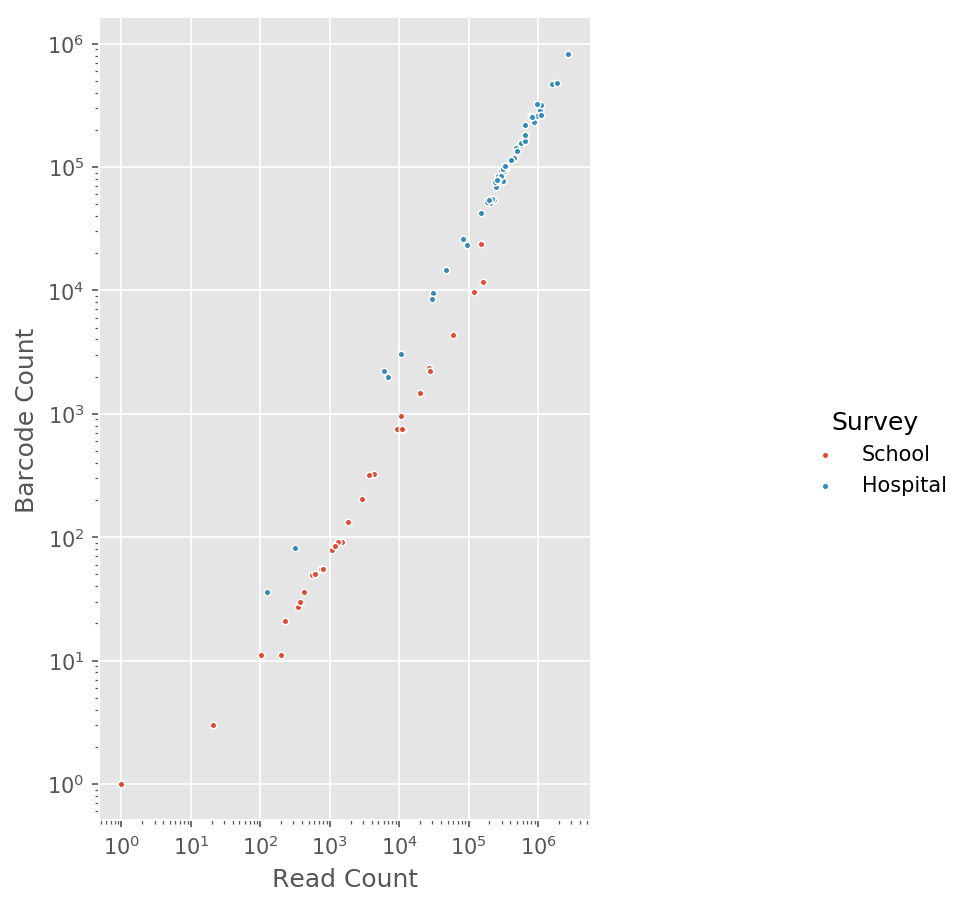

In [57]:
f = sns.pairplot(summary,
            x_vars="Read Count",
            y_vars="Barcode Count", 
                plot_kws={"s": 10},
                hue="Survey")
f.fig.set_dpi(150)
f.fig.set_size_inches(8,8)
f.fig.axes[0].set_xscale("log")
f.fig.axes[0].set_yscale("log")

Low parasitemia school surveys are peforming worse than the hospital samples as expected.

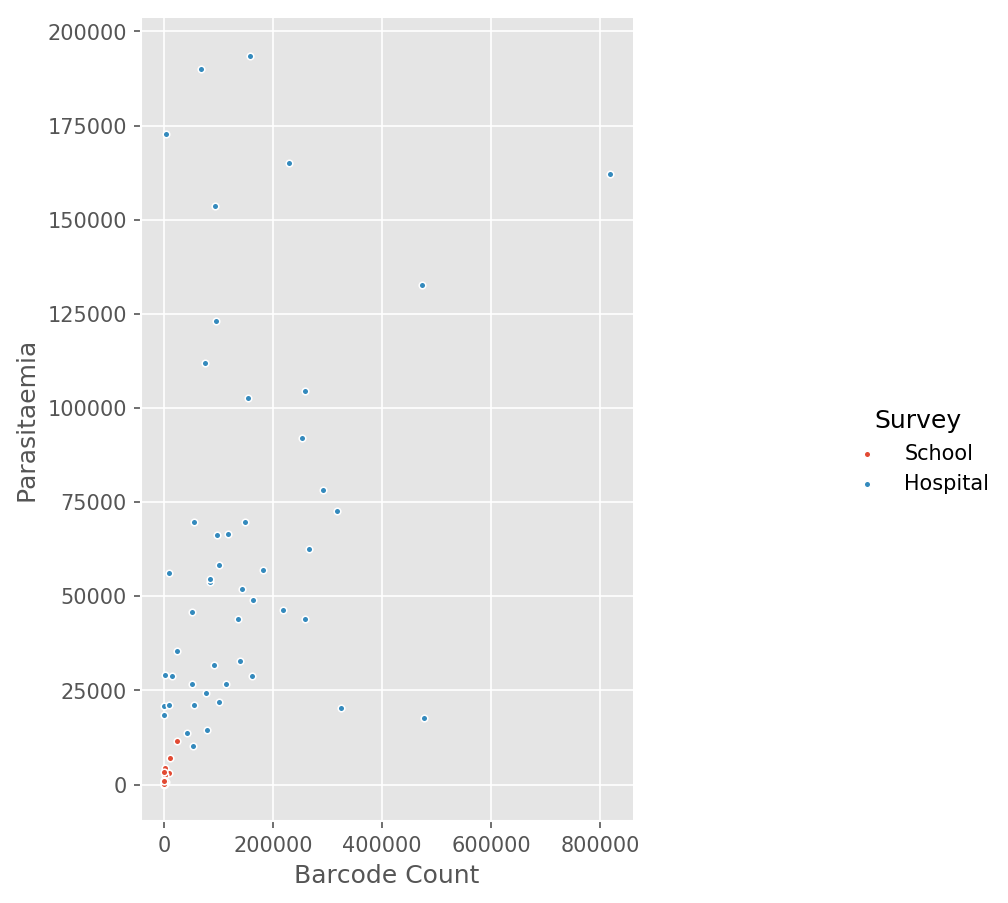

In [79]:
f = sns.pairplot(summary,
            y_vars="Parasitaemia",
            x_vars="Barcode Count", 
                plot_kws={"s": 10},
                hue="Survey")
f.fig.set_dpi(150)
f.fig.set_size_inches(8,8)
#f.fig.axes[0].set_xscale("log")
#f.fig.axes[0].set_yscale("log")

### Plot read count vs the number of probes covered at least at a depth of 10.
This is a good metric to use because for drug resistance  genotype calls, we'd have a minimum coverage threshold of 5 or 10 to make a genotype call. There are 814 probes total, so we would like most samples to have >10 coverage for ~800 probes.

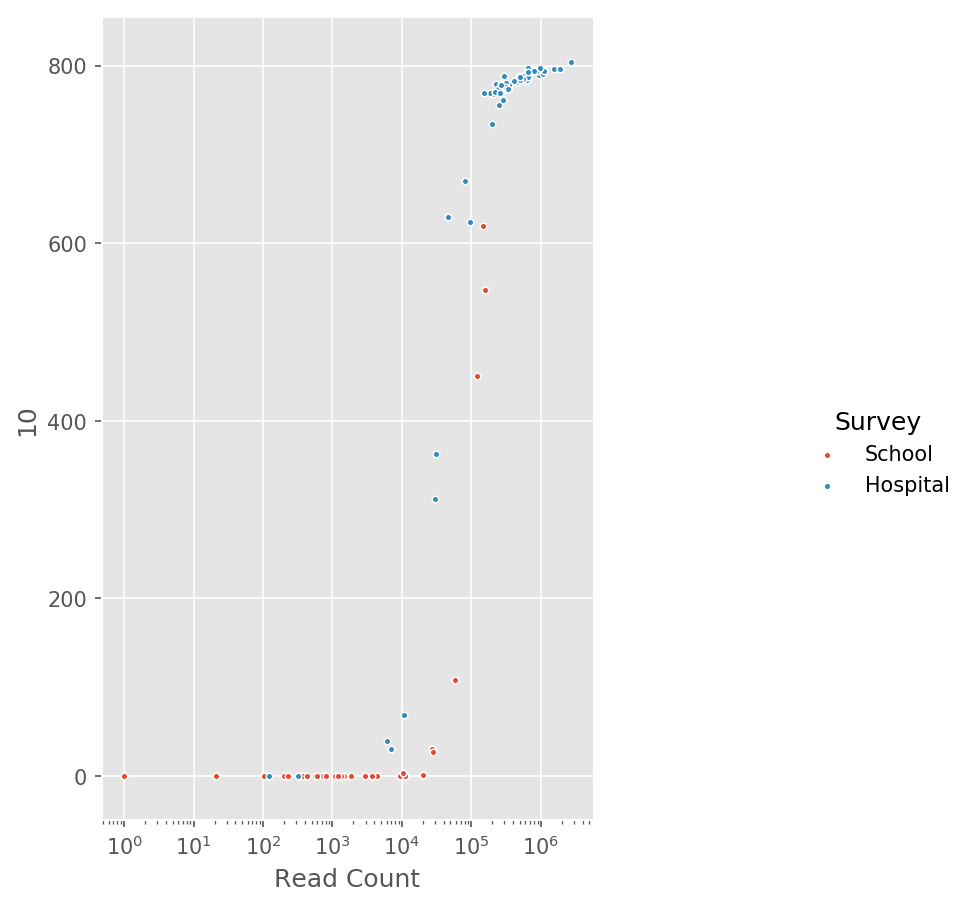

In [58]:
f = sns.pairplot(summary,
            x_vars="Read Count",
            y_vars=10, 
                plot_kws={"s": 10},
                hue="Survey")
f.fig.set_dpi(150)
f.fig.set_size_inches(8,8)
f.fig.axes[0].set_xscale("log")

### It looks like about 200 thousand reads will be needed to cover most loci.

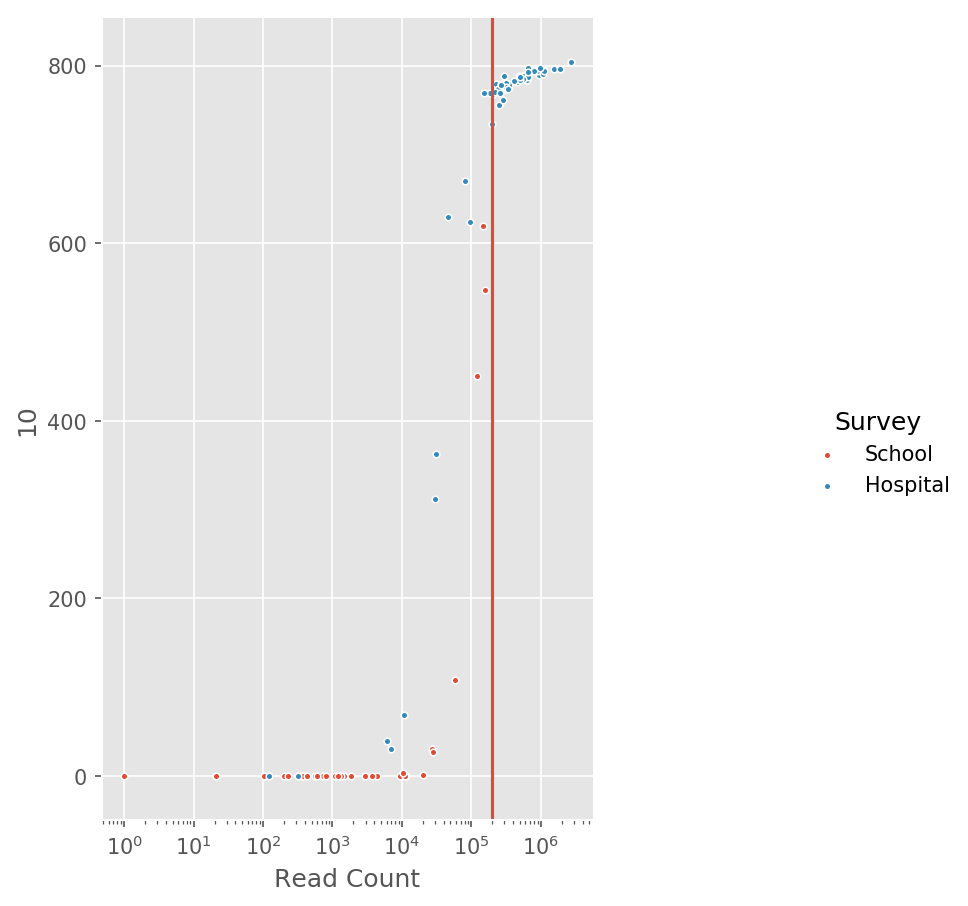

In [61]:
f = sns.pairplot(summary,
            x_vars="Read Count",
            y_vars=10, 
                plot_kws={"s": 10},
                hue="Survey")
f.fig.set_dpi(150)
f.fig.set_size_inches(8,8)
f.fig.axes[0].set_xscale("log")
f.fig.axes[0].axvline(200000)

### Filter data to samples with enough coverage to see how each probe is performing in good samples
How many samples pass the 200,000 reads threshold?

In [62]:
good_samples = summary.loc[summary["Read Count"] >= 200000, "Sample ID"]
good_samples.shape

(41,)

### Start with targeted SNP genotyping ratio.

In [63]:
targeted_mutations.loc[good_samples].count()/len(good_samples)

Gene           Mutation Name        ExonicFunc       
PF3D7-1322700  PF3D7-1322700-T236I  nonsynonymous SNV    1.000000
PF3D7-1451200  PF3D7-1451200-N71N   synonymous SNV       1.000000
Sec14          Sec14-L498F          NA                   0.000000
               Sec14-N615D          nonsynonymous SNV    1.000000
arps10         arps10-V127M         NA                   1.000000
atp6           atp6-A623E           nonsynonymous SNV    1.000000
               atp6-E431K           nonsynonymous SNV    1.000000
               atp6-L263E           NA                   1.000000
               atp6-S769N           NA                   1.000000
crt            crt-A220S            nonsynonymous SNV    1.000000
               crt-C101F            NA                   1.000000
               crt-C72S             nonsynonymous SNV    1.000000
               crt-F145I            NA                   1.000000
               crt-H97L             NA                   1.000000
               crt-H97

### How well the target genes covered
Start by looking at genes we would like to cover the most: crt, k13

In [64]:
cols = barcode_counts.columns
crt = [c[0] for c in cols if c[0].startswith("crt")]
crt = sorted(crt, key=lambda a: int(a.split("_")[-1][3:]))
k13 = [c[0] for c in cols if c[0].startswith("k13")]
k13 = sorted(k13, key=lambda a: int(a.split("_")[-1][3:]))

### Get the fraction of the probes with >=10 coverage for k13 across "good samples"

In [65]:
((barcode_counts.loc[good_samples] >= 10).sum()/len(good_samples)).loc[k13]

MIP                Copy
k13_S0_Sub0_mip1   C0      1.0
k13_S0_Sub0_mip10  C0      1.0
k13_S0_Sub0_mip11  C0      1.0
k13_S0_Sub0_mip12  C0      1.0
k13_S0_Sub0_mip13  C0      1.0
k13_S0_Sub0_mip14  C0      1.0
k13_S0_Sub0_mip15  C0      1.0
k13_S0_Sub0_mip2   C0      1.0
k13_S0_Sub0_mip3   C0      1.0
k13_S0_Sub0_mip4   C0      1.0
k13_S0_Sub0_mip5   C0      1.0
k13_S0_Sub0_mip6   C0      1.0
k13_S0_Sub0_mip7   C0      1.0
k13_S0_Sub0_mip8   C0      1.0
k13_S0_Sub0_mip9   C0      1.0
dtype: float64

### k13 is fully sequenced for all of the good samples.

In [66]:
((barcode_counts.loc[good_samples] >= 10).sum()/len(good_samples)).loc[crt]

MIP                Copy
crt_S0_Sub0_mip1   C0      1.000000
crt_S0_Sub0_mip10  C0      0.975610
crt_S0_Sub0_mip11  C0      0.951220
crt_S0_Sub0_mip12  C0      1.000000
crt_S0_Sub0_mip13  C0      1.000000
crt_S0_Sub0_mip14  C0      1.000000
crt_S0_Sub0_mip15  C0      1.000000
crt_S0_Sub0_mip16  C0      0.463415
crt_S0_Sub0_mip17  C0      1.000000
crt_S0_Sub0_mip18  C0      1.000000
crt_S0_Sub0_mip19  C0      1.000000
crt_S0_Sub0_mip2   C0      1.000000
crt_S0_Sub0_mip20  C0      0.341463
crt_S0_Sub0_mip21  C0      0.219512
crt_S0_Sub0_mip22  C0      1.000000
crt_S0_Sub0_mip23  C0      1.000000
crt_S0_Sub0_mip3   C0      0.024390
crt_S0_Sub0_mip4   C0      1.000000
crt_S0_Sub0_mip5   C0      1.000000
crt_S0_Sub0_mip6   C0      1.000000
crt_S0_Sub0_mip7   C0      1.000000
crt_S0_Sub0_mip8   C0      0.219512
crt_S0_Sub0_mip9   C0      0.024390
dtype: float64

### crt is a little spotty at some places.
Calculate how many crt probes have good coverage in > 95% of the samples.

In [68]:
(((barcode_counts.loc[good_samples] >= 10).sum()/len(good_samples)).loc[crt]>0.95).value_counts()

True     17
False     6
dtype: int64

17 of 23 probes are in good standing. Not great, but considering this is crt, not too bad either. A few of these probes may improve when added in higher concentration but the worst  performers will not likely do better. This means we would be able to sequence about 75% of the crt sequence.

### Finally, do a similar analysis across all probes. See how many have sufficient coverage for > 95% of the good samples.

In [74]:
(((barcode_counts.loc[good_samples] >= 10).sum()/len(good_samples))>0.95).value_counts()

True     755
False     59
dtype: int64

### Bonus
Plot a correlation heatmap of  all numeric values in the summary.

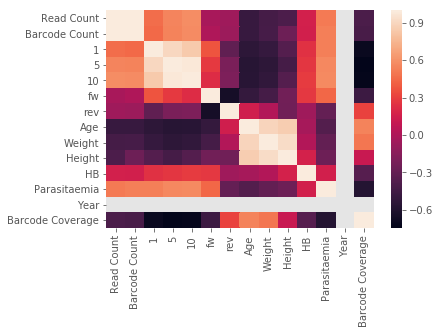

In [76]:
sns.heatmap(summary.corr())

I see 3 correlation groups that are pretty obvious. 
1.  More read/barcode counts are correlated with the number of probes covered with 1/5/10 barcodes.
2.  Weight, height and age of the sample donors are correlated.
3.  As expected, parasitemia values are also correelated with the MIP count data.

In [77]:
summary.to_csv(wdir + "summary.csv", index=False)